### Importing Required Libraries

In [36]:
# Standard libraries for file handling and numerical operations
import os  
import numpy as np  
import pandas as pd 

# Audio Processing
import librosa  
import librosa.display  

# To Displays progress bars for loops
from tqdm import tqdm 

# Image Processing library for resizing and processing spectrogram images
import cv2 

# TensorFlow framework for deep learning
import tensorflow as tf  
from tensorflow.keras.applications import VGG16  # Pretrained VGG16 model
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D  
from tensorflow.keras.utils import to_categorical  

# Data Preprocessing
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder  

# Visualization
import matplotlib.pyplot as plt  
import seaborn as sns 

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report 

### Define Dataset Path

In [37]:
dataset_root = r"I:\My Drive"
dataset_subfolders = ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]

### Define emotions based on RAVDESS Dataset

In [38]:
emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
               '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}

### Ensuring dataset_features directory exists

In [39]:
output_dir = r"I:\My Drive\SpeechEmotionDetection\dataset_features"
os.makedirs(output_dir, exist_ok=True)

### Audio Feature Extraction
This function extracts three key features from an audio file:
1. **MFCCs (Mel-Frequency Cepstral Coefficients)**
    - Captures timbral characteristics of speech.
    - Timbre refers to the quality or color of a sound that makes it distinct from other sounds, even when they have the same pitch and loudness.
2. **Chroma Features** 
    - Represents pitch class distribution in the audio.
3. **Mel Spectrogram** 
    - Shows energy distribution over different frequencies.

These features are essential for training a machine learning model to classify speech emotions

In [40]:
def extract_mel_spectrogram(file_path, img_size=(224, 224)):
    """Extracts a Mel Spectrogram from an audio file and returns it as a 3-channel image"""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Resize to VGG16 input size (224x224)
        mel_spec_resized = cv2.resize(mel_spec_db, img_size, interpolation=cv2.INTER_LINEAR)

        # Normalize spectrogram values
        mel_spec_resized = (mel_spec_resized - mel_spec_resized.min()) / (mel_spec_resized.max() - mel_spec_resized.min())

        # Convert to 3-channel image format
        mel_spec_rgb = np.stack([mel_spec_resized] * 3, axis=-1)

        return mel_spec_rgb
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

### Data Processing

In [41]:
def process_dataset(dataset_path, category, data, labels):
    """Processes audio files from a dataset directory and extracts features"""
    all_files = []
    
    for actor_folder in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_folder)
        
        # Ignore non-actor folder
        if not os.path.isdir(actor_path):
            continue

        for file_name in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file_name)
            # Ignore non-audio files 
            if not file_name.lower().endswith(".wav"):
                continue  

            all_files.append((file_path, file_name))

    # Display processing of files found in the category
    print(f"Processing {category}: {len(all_files)} files")

    # Process each audio file and extract features
    for file_path, file_name in tqdm(all_files, desc=f"Extracting from {category}"):
        try:
            spectrogram = extract_mel_spectrogram(file_path)
            if spectrogram is not None:
                emotion_code = file_name.split("-")[2]
                if emotion_code in emotion_map:
                    data.append(spectrogram)
                    labels.append(int(emotion_code) - 1)  # Convert emotion to index
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

In [42]:
# # Initializing empty list to store extracted data and labels
data = []
labels = []

# Process each dataset subfolder
for subfolder in dataset_subfolders:
    dataset_path = os.path.join(dataset_root, subfolder)
    if os.path.exists(dataset_path):
        process_dataset(dataset_path, subfolder, data, labels)
    else:
        print(f"Warning: {dataset_path} does not exist. Skipping.")

Processing Audio_Speech_Actors_01-24: 1440 files


Extracting from Audio_Speech_Actors_01-24: 100%|██████████| 1440/1440 [00:48<00:00, 29.93it/s]


Processing Audio_Song_Actors_01-24: 1012 files


Extracting from Audio_Song_Actors_01-24: 100%|██████████| 1012/1012 [00:41<00:00, 24.32it/s]


In [43]:
# Convert extracted features to NumPy arrays
X = np.array(data)
y = to_categorical(np.array(labels), num_classes=8)  # One-hot encoding for 8 emotions

In [44]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape}, Validation samples: {X_val.shape}")

Training samples: (1961, 224, 224, 3), Validation samples: (491, 224, 224, 3)


### Define VGG-based model

In [45]:
# Define VGG16-based model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

### Define VGG Model
* VGG16 is a deep convolutional neural network (CNN) developed by the Visual Geometry Group (VGG) at Oxford. 
* It consists of 16 layers, primarily using 3×3 convolutional filters and max pooling, making it highly effective for image classification. It was a top performer in the ImageNet competition (ILSVRC-2014).

* Although designed for images, VGG16 can be applied to audio-based tasks by converting sound waves into Mel spectrograms (image representations of sound). The key benefits include:
    - **Pre-trained on ImageNet** → Strong feature extraction.
    - **Transfer Learning** → Reduces training time and improves accuracy.
    - **Effective Pattern Recognition** → Learns complex emotional cues in speech.

* VGG16’s structured architecture and transfer learning capability make it ideal for speech emotion recognition, allowing us to classify emotions efficiently from audio data.

In [46]:
# Adding custom classifier

# Apply Global Average Pooling to reduce the spatial dimensions of the feature maps
x = base_model.output
x = GlobalAveragePooling2D()(x)
# First fully connected dense layer
x = Dense(256, activation="relu")(x)
# Dropout layer (50%) to reduce overfitting
x = Dropout(0.5)(x)
# Second fully connected dense layer
x = Dense(128, activation="relu")(x)
# Dropout layer (30%) to reduce overfitting
x = Dropout(0.3)(x)
# Output layer with 8 neurons (for each emotion category) and softmax activation for multi-class classification
output_layer = Dense(8, activation="softmax")(x)

In [47]:
# Define final model
vgg_model = Model(inputs=base_model.input, outputs=output_layer)

In [48]:
# Compile the model & get summary
vgg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
vgg_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,879,944 (56.76 MB)

 Trainable params: 165,256 (645.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
# Train the Model
history = vgg_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.1459 - loss: 2.1629 - val_accuracy: 0.2851 - val_loss: 1.9668
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 342s 6s/step - accuracy: 0.2287 - loss: 1.9714 - val_accuracy: 0.3075 - val_loss: 1.8661
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.2369 - loss: 1.8777 - val_accuracy: 0.3055 - val_loss: 1.7597
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.2695 - loss: 1.7850 - val_accuracy: 0.3136 - val_loss: 1.7142
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.2875 - loss: 1.7237 - val_accuracy: 0.3014 - val_loss: 1.6238
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.3055 - loss: 1.6851 - val_accuracy: 0.4155 - val_loss: 1.5882
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.3572 - loss: 1.6143 - val_accuracy: 0.4236 - val_loss: 1.5345
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.3551 - loss: 1.5926 - val_accuracy: 0.4481 - v

In [ ]:
# Save trained model
vgg_model.save("I:\My Drive\SpeechEmotionDetection\models\speech_emotion_vgg16_model.h5")
print("Model trained and saved!")

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\EL-Dorado\AppData\Local\Temp\ipykernel_23900\180806623.py:2: SyntaxWarning: invalid escape sequence '\M'
  vgg_model.save("I:\My Drive\SpeechEmotionDetection\models\speech_emotion_vgg16_model.h5")


Model trained and saved!


### Model Evaluation 📊
- Model evaluation is the process of assessing how well a trained model performs on unseen data. It helps determine accuracy, robustness, and generalization before deployment.
- Once the model is trained, we evaluate its performance using various metrics:
    1. **Accuracy** - Measures overall correctness.
    2. **Precision & Recall** - Important for imbalanced datasets.
    3. **F1-Score** - Balances precision and recall.
    4. **Confusion Matrix** - Provides a detailed view of model errors.
    5. **Loss Function** - Determines model optimization.

We will use **Scikit-learn** to compute these metrics and visualize performance.

In [57]:
# Evaluate model with confusion matrix
y_pred = np.argmax(vgg_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred, target_names=emotion_map.values()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step
              precision    recall  f1-score   support

     neutral       0.43      0.38      0.41        34
        calm       0.60      0.69      0.64        85
       happy       0.44      0.19      0.26        85
         sad       0.40      0.25      0.30        69
       angry       0.62      0.79      0.69        70
     fearful       0.55      0.72      0.62        75
     disgust       0.59      0.61      0.60        33
   surprised       0.59      0.90      0.71        40

    accuracy                           0.55       491
   macro avg       0.53      0.57      0.53       491
weighted avg       0.52      0.55      0.52       491



### Confusion Matrix Visualization 🎯
A **confusion matrix** is a useful tool to evaluate the performance of a classification model. It shows:
- **Correct classifications** along the diagonal.
- **Misclassifications** off the diagonal.

We use **Seaborn’s heatmap** to visually analyze model errors and performance.

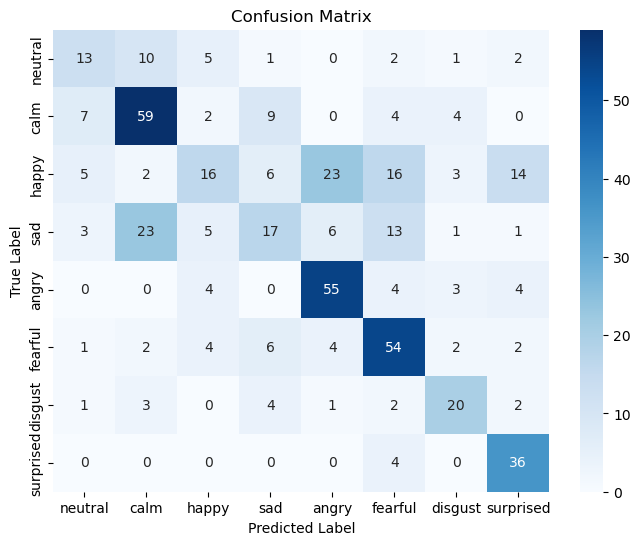

In [58]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_map.values(), yticklabels=emotion_map.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

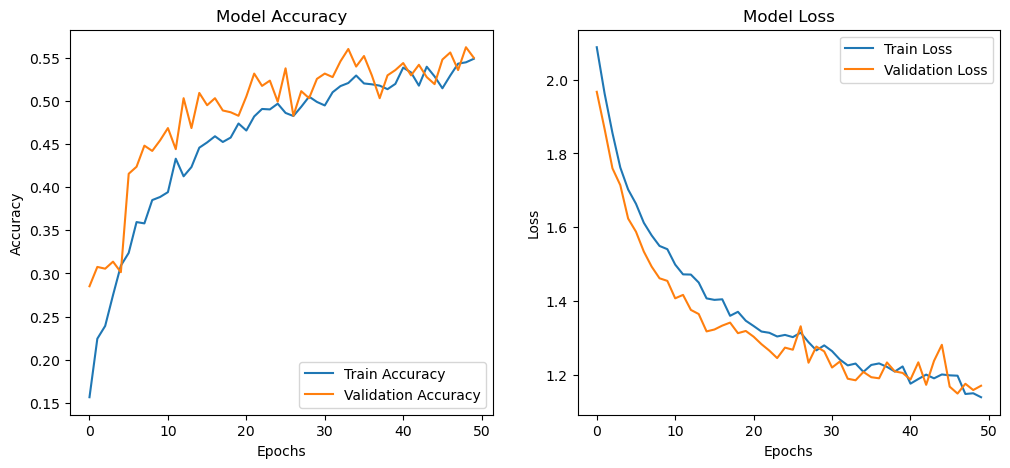

In [59]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()